# Análise Exploratória dos dados

### Objetivo

Nesta etapa, validamos os dados para construir um painel gerencial de um e-commerce, que busca analisar suas vendas e definir estratégias para alavancar resultados. 

Também será desenvolvido um modelo de séries temporais para prever as vendas dos próximos 60 dias.

---

### Dados utilizados

Contamos com duas bases localizadas em `data/raw`:

- `tbl_clientes`
- `tbl_vendas`

Para entender a estrutura dos dados, consulte a imagem `metadados.png` na pasta `references`.

---

### Observações

- Não possuímos detalhes sobre a origem dos dados.
- Não temos contato com o time de negócios para auxiliar na validação.



### Etapas de Validação e Preparação dos dados

#### 1. Exploração Inicial e Validação dos Dados
- Amostragem e verificação dos tipos de dados das tabelas.
- Verificação de valores únicos de `id` na `tbl_clientes`.
- Remoção de duplicatas na coluna `id` da `tbl_clientes`.
- Identificação de clientes na   `tbl_vendas` que não estão presentes na `tbl_clientes`.

#### 2. Enriquecimento e Tratamento de Dados
- Construção da coluna `estado` na `tbl_vendas`.
- Construção da coluna `vl_frete` na `tbl_vendas`.
- Verificação de valores únicos na coluna `idcompra` na `tbl_vendas`.
- Tratamento da coluna `idcanalpedidos` na `tbl_vendas`.
- Construção da coluna `Nome_Departamento_ajustado` a partir da `Nome_Departamento`.

#### 3. Preparação da Tabela de Previsão
- Criação da `tabela_previsão` para treinamento do modelo.
- Inserção da coluna de data como índice.
- Aplicação de `resample` diário na `tabela_previsão`.

#### 4. Análise Exploratória da Série Temporal
- Visualização dos dados em formato de série temporal.
- Análise descritiva dos dados da `tabela_previsão`.
- Verificação de outliers e validação de técnica de ajuste.
- Plotagem de histograma da variável-alvo.

#### 5. Feature Engineering
- Criação de colunas de média móvel e *lags*.
- Enriquecimento com atributos temporais derivados do índice.
- Análise gráfica do *target* com as colunas de lag e média móvel.

#### 6. Análise de Estacionariedade e Sazonalidade
- Teste de estacionariedade da série temporal.
- Gráfico de decomposição (tendência, sazonalidade, ruído).
- Gráficos de autocorrelação (ACF) e autocorrelação parcial (PACF).

#### 7. Armazenamento Final
- Salvamento dos datasets na pasta `processed/`.


## Setup

In [53]:
# carregamento das bibliotecas
import sys
sys.path.append('..')
from src.data.preprocessing import *
from src.data.load_data import salvar_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform


In [ ]:
# carregamento datasets
tbl_vendas = pd.read_excel('../data/raw/Base_de_dados_desafio.xlsx', sheet_name='base compra')
tbl_clientes = pd.read_excel('../data/raw/Base_de_dados_desafio.xlsx', sheet_name='Base cliente')

# Data Wrangling

In [56]:
# amostragem dos dados da tabela vendas
amostra_dados(tbl_vendas)

,idcompra,idcanalvenda,bandeira,Data,Preço,Preço_com_frete,Nome_Departamento,estado,cliente_Log
19753,214155,Aplicativo,B,2021-04-01,319.20,319.20,Informatica,"RJ,Brasil",6945
77501,310685,Aplicativo,A,2021-04-12,26.32,26.32,Acessorios e Inovacoes,"MG,Brasil",10860
49140,251025,Mobile,B,2021-04-06,3439.20,3439.20,Telefones e Celulares,"SP,Brasil",5550


In [57]:
# amostragem dos dados da tabela clientes
amostra_dados(tbl_clientes)

,cliente_Log,idade,uf_nascimento,renda
23389,7814,56,SP,7700
23444,6259,58,AL,14146
22624,19776,36,SP,4971


In [58]:
# informação da tabela de vendas
tbl_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80228 entries, 0 to 80227
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   idcompra           80228 non-null  int64         
 1   idcanalvenda       80228 non-null  object        
 2   bandeira           80228 non-null  object        
 3   Data               80228 non-null  datetime64[ns]
 4   Preço              80228 non-null  float64       
 5   Preço_com_frete    80228 non-null  float64       
 6   Nome_Departamento  80228 non-null  object        
 7   estado             80228 non-null  object        
 8   cliente_Log        80228 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 5.5+ MB


In [59]:
# informação da tabela de clientes
tbl_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26425 entries, 0 to 26424
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cliente_Log    26425 non-null  int64 
 1   idade          26425 non-null  int64 
 2   uf_nascimento  26425 non-null  object
 3   renda          26425 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 825.9+ KB


Base de cadastro problemática

In [60]:
# verificação de id's duplicados na base de cadastro
tbl_clientes.cliente_Log.value_counts()

cliente_Log
27855    7
1563     6
16473    6
26298    6
22913    6
        ..
10268    1
5024     1
4593     1
10884    1
16428    1
Name: count, Length: 17040, dtype: int64

In [61]:
tbl_clientes[tbl_clientes.cliente_Log==27855]

,cliente_Log,idade,uf_nascimento,renda
499,27855,64,SP,13742
656,27855,82,RJ,14296
1327,27855,53,SP,2953
11798,27855,19,RJ,8259
19179,27855,74,RN,10698
19564,27855,36,SP,12222
24084,27855,86,SP,5062


In [62]:
tbl_clientes[tbl_clientes.cliente_Log.duplicated()]

,cliente_Log,idade,uf_nascimento,renda
213,12576,43,RJ,2044
217,13651,25,SP,11436
232,23218,68,RJ,3549
242,8474,70,RS,13567
371,9770,18,SP,11157
...,...,...,...,...
26417,3235,42,SP,8527
26419,2459,84,SP,13120
26421,22379,31,SC,5108
26422,27351,35,RJ,13136


In [63]:
# tratamento de valores duplicados da tabela clientes
tbl_clientes = remover_duplicados(tbl_clientes, 'cliente_Log')
tbl_clientes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17040 entries, 0 to 26424
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cliente_Log    17040 non-null  int64 
 1   idade          17040 non-null  int64 
 2   uf_nascimento  17040 non-null  object
 3   renda          17040 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 665.6+ KB


In [64]:
# verificação de valores duplicados após tratamento
valores_duplicados = tbl_clientes['cliente_Log'].value_counts()

contagens_filtradas = valores_duplicados[valores_duplicados > 1]
contagens_filtradas



Series([], Name: count, dtype: int64)

In [66]:
# verificação de duplicados
(
    tbl_clientes.groupby(tbl_clientes.columns.tolist(), dropna=False)
    .size()
    .to_frame('n_duplicates')
    .query('n_duplicates>1')
    .sort_values(by ='n_duplicates', ascending=False)
    .head(5)
)

,,,,n_duplicates
cliente_Log,idade,uf_nascimento,renda,


# Clientes não-localizados

In [69]:
# juncao das tabelas
clientes_sem_cadastro = tbl_vendas.merge(tbl_clientes, on='cliente_Log', how='left')
clientes_sem_cadastro

,idcompra,idcanalvenda,bandeira,Data,Preço,Preço_com_frete,Nome_Departamento,estado,cliente_Log,idade,uf_nascimento,renda
0,393835,Mobile,A,2021-03-30,791.280,791.280,Telefones e Celulares,"SP,Brasil",14098,37.0,SP,6757.0
1,411885,Mobile,A,2021-03-30,679.200,679.200,Tablets,"SP,Brasil",24992,NaN,NaN,NaN
2,437305,Mobile,A,2021-03-30,35.920,37.512,Bebes,"SP,Brasil",9870,88.0,PR,10789.0
3,440055,Aplicativo,A,2021-03-30,2239.416,2239.416,TVs e Acessorios,"SP,Brasil",171,NaN,NaN,NaN
4,455795,Mobile,B,2021-03-30,1743.200,1785.112,Esporte e Lazer,"RS,Brasil",12181,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
80223,636930,Aplicativo,B,2021-04-09,879.200,879.200,Telefones e Celulares,"RJ,Brasil",7707,28.0,MG,14647.0
80224,658550,Aplicativo,B,2021-04-09,879.200,879.200,Telefones e Celulares,"AM,Brasil",5925,51.0,MG,8568.0
80225,680170,Aplicativo,B,2021-04-09,879.200,879.200,Telefones e Celulares,"PB,Brasil",246,74.0,DF,1724.0
80226,701790,Aplicativo,B,2021-04-09,879.200,879.200,Telefones e Celulares,"PB,Brasil",21595,86.0,RJ,4108.0


## Verificar o percentual dos clientes sem cadastro representam do volume total de vendas.

In [72]:
tbl_vendas['sigla_estado'] = tbl_vendas['estado'].str.split(",").str[0]


In [74]:
# construção da coluna com o valor de frete
tbl_vendas['vl_frete'] =tbl_vendas['Preço_com_frete'] - tbl_vendas['Preço']

In [75]:
tbl_vendas.idcompra.value_counts()

idcompra
334870    5
394310    5
393660    5
303265    5
307685    5
         ..
8240      1
4025      1
481885    1
422515    1
344460    1
Name: count, Length: 38940, dtype: int64

# Tratamento coluna idcanalvenda

In [82]:
tbl_vendas.idcanalvenda.value_counts()

idcanalvenda
Mobile        5613
Internet      5596
Aplicativo    4715
Mobil          101
Name: count, dtype: int64

In [83]:
tbl_vendas.idcanalvenda.replace({'Mobil':'Mobile'},inplace=True)

C:\Users\ederr\AppData\Local\Temp\ipykernel_9404\2459699549.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tbl_vendas.idcanalvenda.replace({'Mobil':'Mobile'},inplace=True)


In [84]:
frequencia = tbl_vendas['Nome_Departamento'].value_counts(normalize=True)
frequencia

Nome_Departamento
Telefones e Celulares     0.171232
Eletroportateis           0.132106
Eletrodomesticos          0.125554
Informatica               0.077254
TVs e Acessorios          0.063526
Bebes                     0.061529
Beleza e Saude            0.058846
Utilidades Domesticas     0.057910
Moveis                    0.049485
Acessorios e Inovacoes    0.047925
Tablets                   0.023588
Audio                     0.021279
Brinquedos                0.016661
Ferramentas               0.016162
Automotivo                0.013292
Ar e Ventilacao           0.012605
Produtos de Limpeza       0.011108
Games                     0.009423
Perfumaria                0.009298
Esporte e Lazer           0.007426
Casa e Construcao         0.004618
Cama, Mesa e Banho        0.002246
Relogios                  0.002059
Decoracao                 0.001997
Malas e Mochilas          0.001560
Linha Industrial          0.000811
Pet Shop                  0.000312
TV e Video                0.000062
Ci

In [85]:
categorias_comuns = frequencia[frequencia > 0.04].index  

tbl_vendas['Nome_Departamento_ajustado']= tbl_vendas['Nome_Departamento'].where(tbl_vendas['Nome_Departamento'].isin(categorias_comuns), 'Outros')


In [86]:
tbl_vendas.idcanalvenda.value_counts()

idcanalvenda
Mobile        5714
Internet      5596
Aplicativo    4715
Name: count, dtype: int64

# Construção da tabela de previsão

In [87]:
# seleção das colunas para a tabela de previsão
tbl_previsao = selecao_colunas(df=tbl_vendas, colunas=['Data','sigla_estado','idcanalvenda','bandeira','Nome_Departamento_ajustado','Preço', 'vl_frete'])

In [88]:
# transformação de coluna data em index da tabela
tbl_vendas.set_index('Data', inplace=True)

In [89]:
# agrupamento dos dados para criação da tabela de previsão
tbl_previsao = tbl_vendas[['Preço']].resample('D').sum()

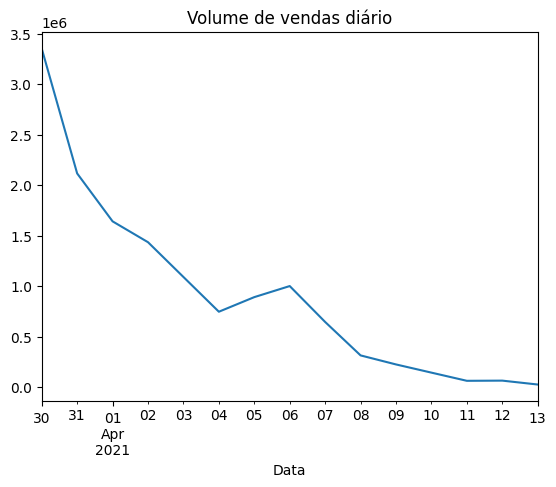

In [90]:
# visualização dos dados
tbl_previsao.plot(title='Volume de vendas diário', legend=False);


In [91]:
tbl_previsao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2021-03-30 to 2021-04-13
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Preço   15 non-null     float64
dtypes: float64(1)
memory usage: 240.0 bytes


In [92]:
tbl_previsao.describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95])

,Preço
count,1.500000e+01
mean,9.177545e+05
std,9.250732e+05
min,2.719463e+04
10%,6.463054e+04
25%,1.853775e+05
50%,7.475031e+05
75%,1.263291e+06
90%,1.926304e+06
95%,2.486774e+06


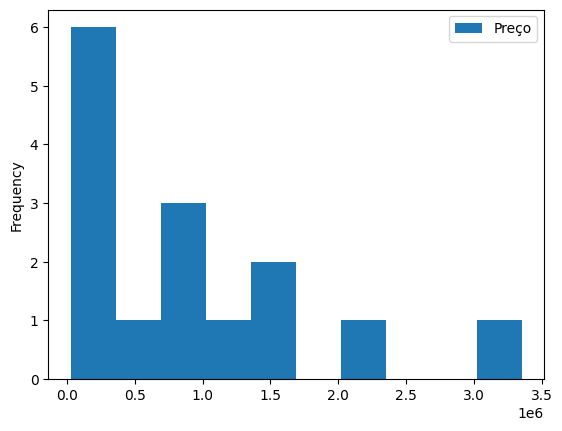

In [93]:
tbl_previsao[['Preço']].plot.hist();


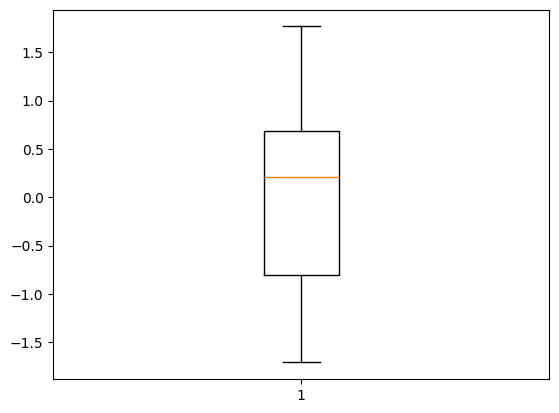

In [94]:
plt.boxplot(power_transform(tbl_previsao[['Preço']], method='box-cox'));

In [96]:
# inserção das coluneas de média móvel na tabela
tbl_previsao = media_movel(tbl_previsao, coluna='Preço', p=[2,3,5,7])
tbl_previsao.head()

,Preço,Preço_rm_2,Preço_rm_3,Preço_rm_5,Preço_rm_7
Data,,,,,
2021-03-30,3351925.408,NaN,NaN,NaN,NaN
2021-03-31,2115995.264,2733960.336,NaN,NaN,NaN
2021-04-01,1641767.952,1878881.608,2.369896e+06,NaN,NaN
2021-04-02,1435357.032,1538562.492,1.731040e+06,NaN,NaN
2021-04-03,1091225.688,1263291.360,1.389450e+06,1.927254e+06,NaN


In [97]:
# inserção das colunas de lags no dataset
tbl_previsao = lag_data(tbl_previsao, coluna='Preço', lag=[2,3,5,7])
tbl_previsao.head()

,Preço,Preço_rm_2,Preço_rm_3,Preço_rm_5,Preço_rm_7,Preço_lag_2,Preço_lag_3,Preço_lag_5,Preço_lag_7
Data,,,,,,,,,
2021-03-30,3351925.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-31,2115995.264,2733960.336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,1641767.952,1878881.608,2.369896e+06,NaN,NaN,3351925.408,NaN,NaN,NaN
2021-04-02,1435357.032,1538562.492,1.731040e+06,NaN,NaN,2115995.264,3351925.408,NaN,NaN
2021-04-03,1091225.688,1263291.360,1.389450e+06,1.927254e+06,NaN,1641767.952,2115995.264,NaN,NaN


<Axes: xlabel='Data'>

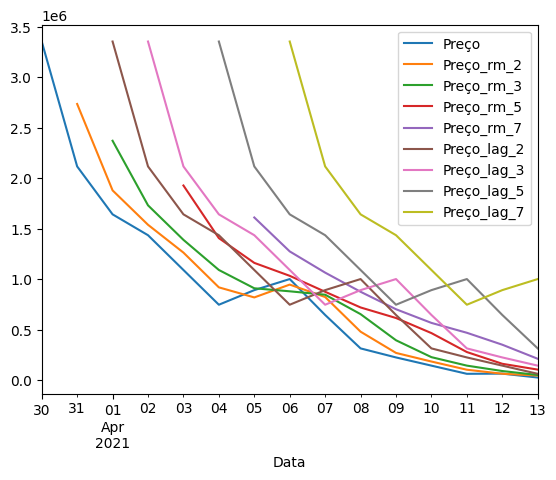

In [98]:
tbl_previsao.plot()

## Gerar suplot comparando o lag com o dado histórico

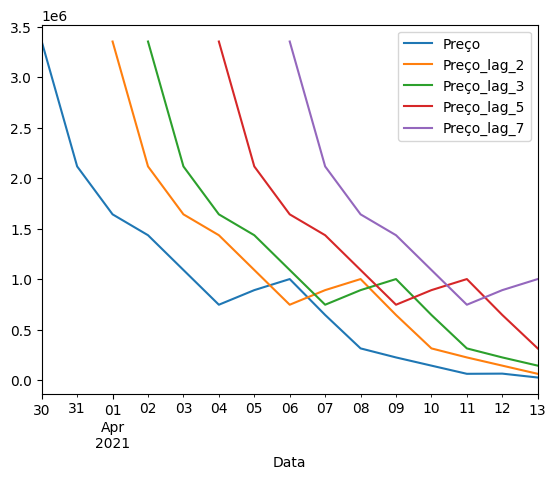

In [99]:


tbl_previsao[['Preço', 'Preço_lag_2', 'Preço_lag_3', 'Preço_lag_5','Preço_lag_7']].plot();

In [100]:
# inserção de colunas de complemento de informação de data do index
tbl_previsao = dados_temporais(tbl_previsao)
tbl_previsao.head()

,Preço,Preço_rm_2,Preço_rm_3,Preço_rm_5,Preço_rm_7,Preço_lag_2,Preço_lag_3,Preço_lag_5,Preço_lag_7,Dia_Semana,Mês,Feriado
Data,,,,,,,,,,,,
2021-03-30,3351925.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,3,False
2021-03-31,2115995.264,2733960.336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,3,False
2021-04-01,1641767.952,1878881.608,2.369896e+06,NaN,NaN,3351925.408,NaN,NaN,NaN,1,4,False
2021-04-02,1435357.032,1538562.492,1.731040e+06,NaN,NaN,2115995.264,3351925.408,NaN,NaN,2,4,True
2021-04-03,1091225.688,1263291.360,1.389450e+06,1.927254e+06,NaN,1641767.952,2115995.264,NaN,NaN,3,4,False


In [102]:
# teste de estacionariedade da série temporal
testar_estacionariedade(tbl_previsao['Preço'], nome='Preço')


🔍 Teste ADF - Preço
ADF Statistic: -6.1428
p-value: 0.0000
Critério 1%%: -4.4731
Critério 5%%: -3.2899
Critério 10%%: -2.7724
✅ Série estacionária (rejeita H₀)


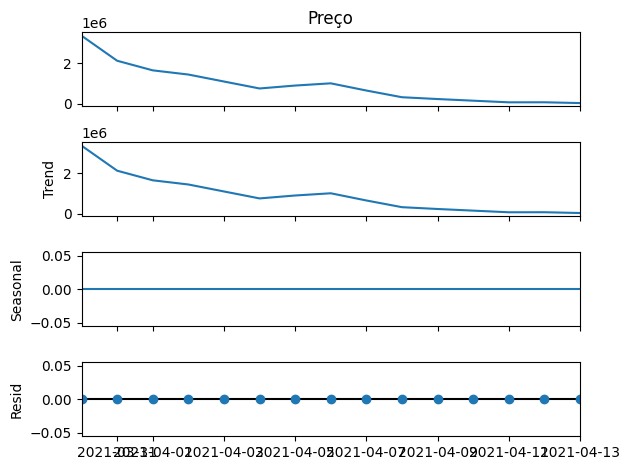

In [103]:
# gráfico de decomposição temporal
grafico_decomposicao_temporal(tbl_previsao, target='Preço', n=1)

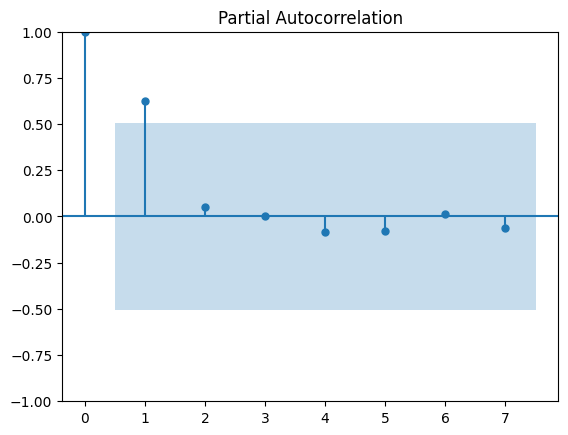

In [104]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(tbl_previsao['Preço'], lags=7, method='ywm')  # método estável para séries reais
plt.show()

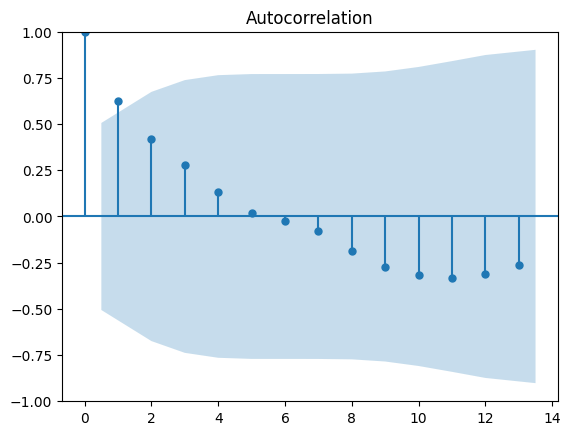

In [105]:
plot_acf(tbl_previsao['Preço'], lags=13) 
plt.show()

## Salvando dataset previsão

In [50]:
# salvando o dataset de previsao
salvar_dataset(tbl_previsao, path='../data/processed/dataset_previsao.csv')

# Preciso salvar um dataset tratado de clientes e de vendas pois há duplicação de dados e desconexão que não vamos conseguir corrigir por desconhecimento dos dados.

In [51]:
# salvando o dataset de clientes
salvar_dataset(tbl_clientes, path='../data/processed/dataset_clientes.csv')